In [ ]:
#Title :Clustering Students Based on Lifestyle
#Dataset : Student Lifestyle Dataset from kaggle

!pip install openpyxl

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the dataset
file_path = "data lifestyle student.xlsx"
# Use the 'engine' parameter to specify openpyxl for reading xlsx files
data = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows of the dataset
data.head()

# Get basic information about the dataset
data.info()

# Check for missing values
print("Missing values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    2000 non-null   float64
 1   Jam_Belajar_Per_Hari          2000 non-null   float64
 2   Jam_Ekstrakurikuler_Per_Hari  2000 non-null   float64
 3   Jam_Tidur_Per_Hari            2001 non-null   object 
 4   Jam_Sosial_Per_Hari           2000 non-null   float64
 5   Jam_Aktivitas_Fisik_Per_Hari  2000 non-null   float64
 6   GPA                           2000 non-null   float64
 7   Stress_Level                  2000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 125.3+ KB
Missing values:
 Student_ID                      2
Jam_Belajar_Per_Hari            2
Jam_Ekstrakurikuler_Per_Hari    2
Jam_Tidur_Per_Hari              1
Jam_Sosial_Per_Hari             2
Jam_Aktivitas_Fisik_Per_Hari    2
GPA                          

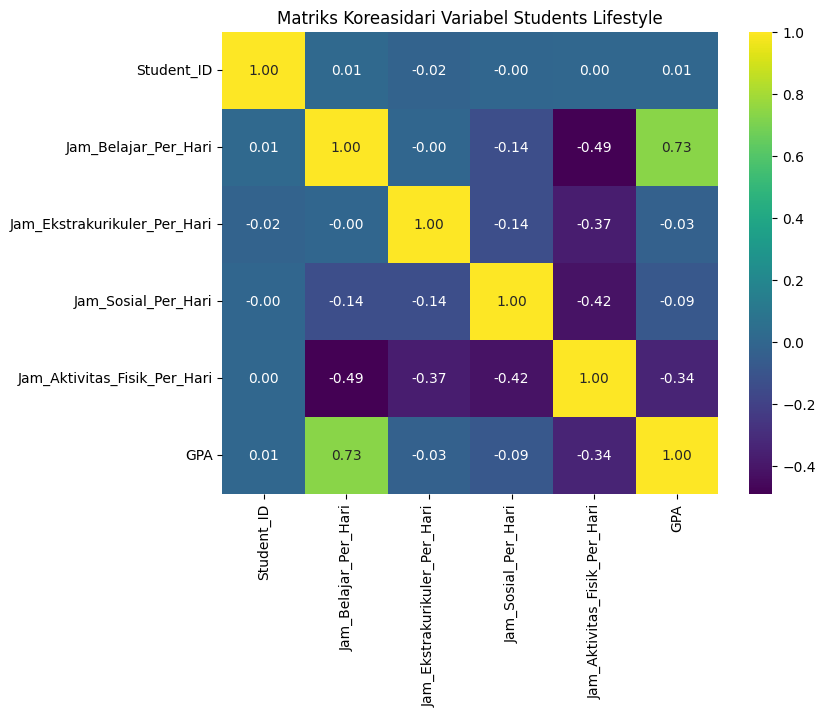

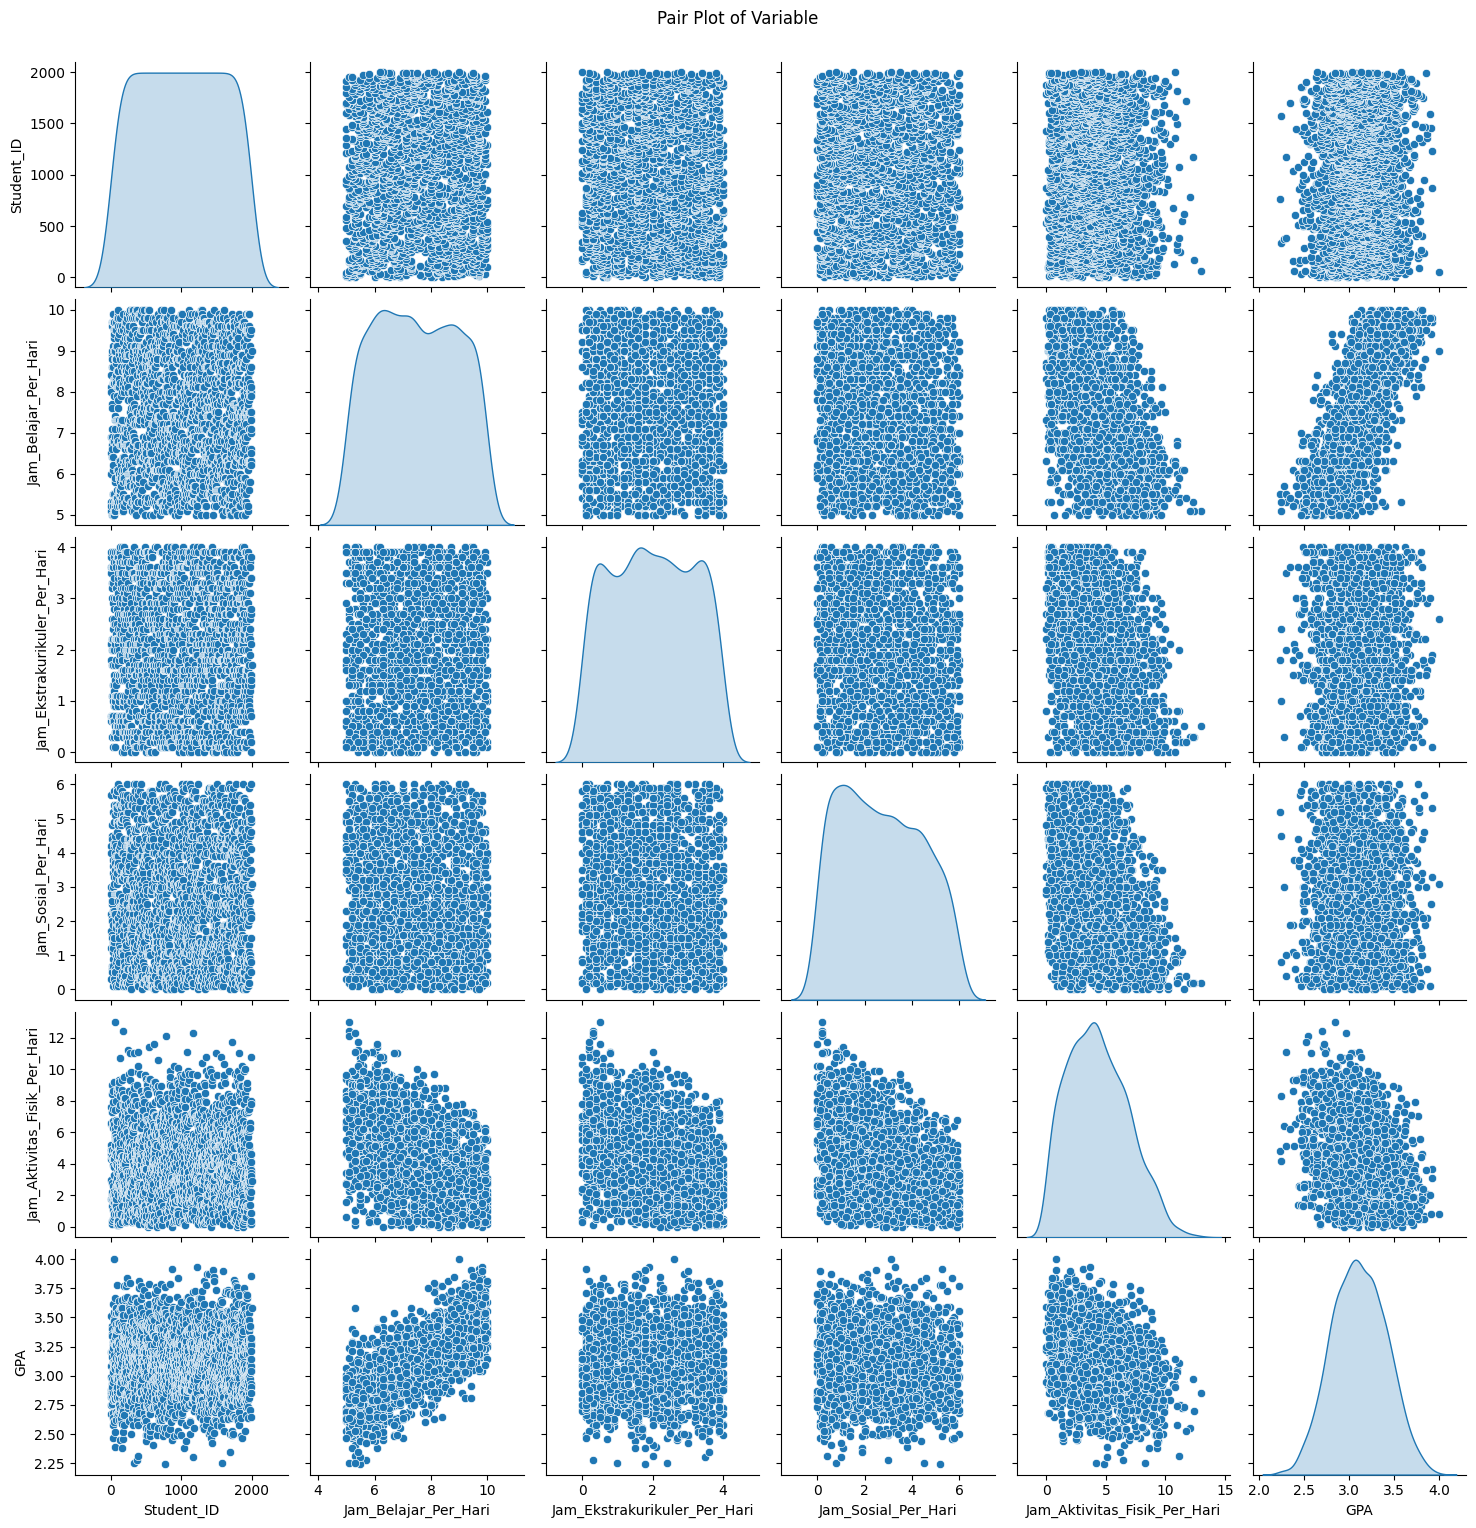

In [ ]:
#Data Visualization (untuk memvisualisasikan pola dan hubungan antara variabel yang berbeda)
#Menggunakan dua metode visualisasi: Heatmap dan Pair Plot, untuk mengeksplorasi hubungan antar fitur.
# 1. Heatmap menunjukkan korelasi antar variabel numerik, membantu mengidentifikasi hubungan seperti korelasi kuat, lemah, atau tidak ada korelasi.
# 2. Pair Plot menyediakan scatter plots and distribution plots untuk memeriksa pola, cluster, atau tren data secara visual.


# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Matriks Koreasidari Variabel Students Lifestyle')
plt.show()


# Pair plot to visualize relationships
sns.pairplot(data, diag_kind='kde')
plt.suptitle('Pair Plot of Variable', y=1.02)
plt.show()

#Hasil dan Analisis:
##----Untuk Heatmap
# - Heatmap mengungkapkan pola korelasi negatif antara "Study_Hours_Per_Day" and "Social_Hours_Per_Day," menunjukkan bahwa lebih banyak jam belajar mungkin mengurangi jam sosial.
# - Variabel seperti "Sleep_Hours_Per_Day" and "Physical_Activity_Hours_Per_Day" show weak or no correlation, artinya mereka independent.
##----Untuk Pair Plot
# - Pair Plot menyediakan scatter plots untuk menyoroti potensi cluster atau tren dalam hubungan variabel.
# - The diagonal KDE plots menunjukkan feature distributions, revealing skewness or normality.
# - visualisasi ini menyediakan scatter plot untuk menyoroti potensi cluster atau tren dalam hubungan variabel.


In [ ]:
#Data Preprocessing
#Mempersiapkan data untuk clustering dengan memilih variabel-variabel penting dan men-skalakannya.
# 1. Pilih variabel numerik yang terkait dengan student lifestyle untuk clustering.
# 2. Standarisasi data sehingga semua variabel berada pada skala yang sama. Hal ini penting karena clustering berfungsi lebih baik dengan data berskala.
# 3.Konversikan kembali data yang diskalakan menjadi DataFrame agar lebih mudah digunakan nanti.

# Select numeric columns untuk clustering
variables = ['Jam_Belajar_Per_Hari', 'Jam_Ekstrakurikuler_Per_Hari',
            'Jam_Tidur_Per_Hari', 'Jam_Sosial_Per_Hari', 'Jam_Aktivitas_Fisik_Per_Hari']
data_clustering = data[variables]

# Convert columns to numeric, errors='coerce' will replace non-numeric values with NaN
for col in variables:
    data_clustering[col] = pd.to_numeric(data_clustering[col], errors='coerce')

# Drop rows with NaN values
data_clustering = data_clustering.dropna()

# Standardize the variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clustering)

# Check if the data is standardized
print("Mean of each variable after scaling:")
print(data_scaled.mean(axis=0))  # Add axis=0 untuk menghitung mean masing-masing variabel

print("\nStandard deviation of each variable after scaling:")
print(data_scaled.std(axis=0))  # Add axis=0 untuk menghitung standard deviation masing-masing variabel

# Convert back to DataFrame for easier handling
data_scaled = pd.DataFrame(data_scaled, columns=variables)

# Results and analysis:
# - Variabel - variabelnya telah berhasil diskalakan, dengan rata-rata mendekati 0 dan deviasi standar mendekati 1.
# - Data sekarang telah dipersiapkan dengan baik untuk clustering.

Mean of each variable after scaling:
[-3.15303339e-16  1.42108547e-17  1.77635684e-16 -1.40332190e-16
 -5.46673817e-16]

Standard deviation of each variable after scaling:
[1. 1. 1. 1. 1.]


<ipython-input-5-36b5f23ef3b3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering[col] = pd.to_numeric(data_clustering[col], errors='coerce')


In [ ]:
# Variable Extraction
# Gunakan Principal Component Analysis (PCA) untuk mengurangi kumpulan data menjadi dua dimensi untuk visualisasi yang lebih baik sambil mempertahankan varian maksimum.
# - PCA digunakan untuk mengurangi dimensi kumpulan data sekaligus menjaga informasi (varians) sebanyak mungkin.
# - Hal ini membantu dalam memvisualisasikan kumpulan data dalam 2D, yang sangat berguna untuk memahami hasil pengelompokan.

# Apply PCA untuk mengurangi dimensi
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Add PCA results to the DataFrame
data_scaled['PCA1'] = data_pca[:, 0]
data_scaled['PCA2'] = data_pca[:, 1]

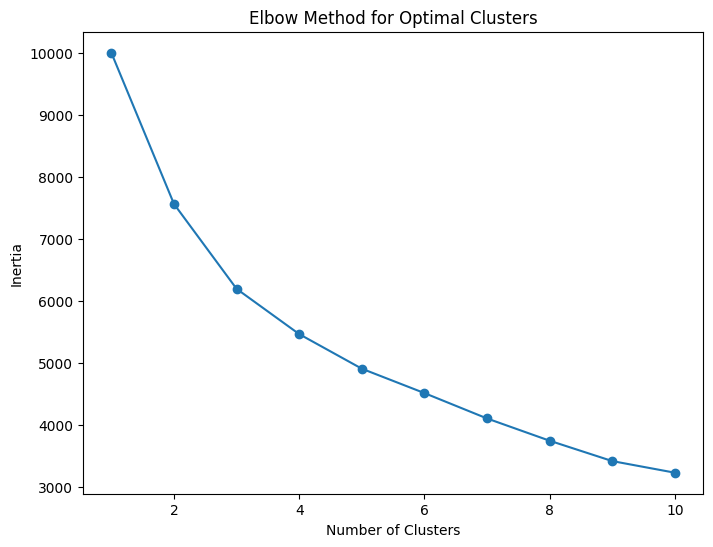

In [ ]:
# Apply Machine Learning Techniques
# Melakukan clustering menggunakan K-Means dengan variasi parameter untuk mengoptimalkan hasil.
# 1. Gunakan Elbow Method untuk menentukan jumlah cluster yang optimal dengan memplot inersia (jumlah kuadrat dalam cluster) untuk nilai k yang berbeda.
# 2. Apply the K-Means algorithm dengan jumlah cluster yang optimal untuk mengelompokkan data berdasarkan kemiripan.

# Determine the optimal number of clusters using the Elbow Method
inertia = []  # Daftar untuk menyimpan inersia untuk setiap nilai k
for k in range(1, 11):  # Test cluster sizes from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize K-Means
    kmeans.fit(data_scaled.iloc[:, :-2])  # Fit K-Means excluding PCA columns
    inertia.append(kmeans.inertia_)  # Store the inertia

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')  # Plot inertia for each value of k
plt.title('Elbow Method for Optimal Clusters')  # Title of the plot
plt.xlabel('Number of Clusters')  # X-axis label
plt.ylabel('Inertia')  # Y-axis label
plt.show()


# Apply K-Means with the optimal number of clusters
optimal_clusters = 3  # Set the optimal number of clusters based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)  # Initialize K-Means
data_scaled['Cluster'] = kmeans.fit_predict(data_scaled.iloc[:, :-2])  # Assign clusters


#Hasil dari Elbow Method:
#Grafik menunjukkan penurunan inersia yang tajam dari k=1 ke k=3, yang menunjukkan bahwa peningkatan jumlah cluster secara signifikan mengurangi variasi dalam cluster.
#Setelah k=3, kurva mulai mendatar, yang berarti manfaat penambahan lebih banyak cluster menjadi minimal.
#Jadi, k=3 adalah elbow point, menjadikannya jumlah cluster yang optimal untuk kumpulan data ini.

#Hasil dari (K-Means Clustering):
# - Setiap titik data telah ditetapkan ke salah satu dari 3 cluster.


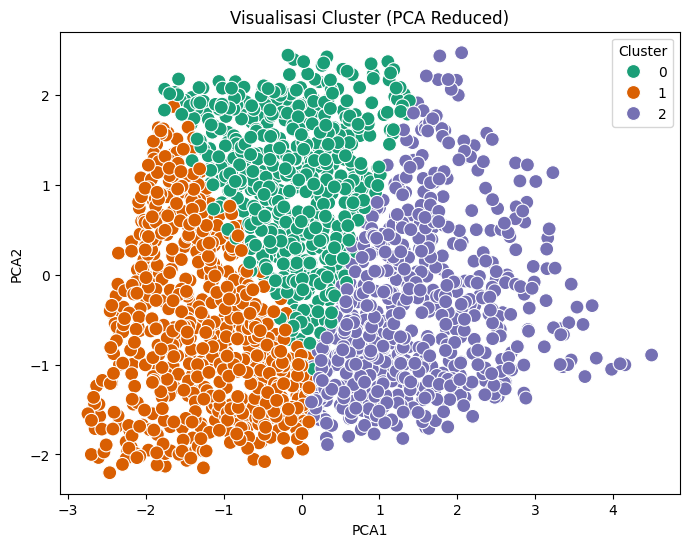

In [ ]:
#experimentation
# Visualisasi Clusters menggunakan PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_scaled, x='PCA1', y='PCA2', hue='Cluster', palette='Dark2', s=100)
plt.title('Visualisasi Cluster (PCA Reduced)')
plt.show()

#Visualisasinya menunjukkan pemisahan yang jelas antar kelompok, yang menunjukkan pola student lifestyle yang berbeda antar kelompok.




In [ ]:
# Hasil Analisis
# Analisis karakteristik dan ukuran setiap cluster untuk memahami pola dari student lifestyles.
# 1. Hitung nilai rata-rata variabel dalam setiap cluster untuk memahami karakteristik unik setiap grup.
# 2. Hitung jumlah siswa di setiap cluster untuk melihat bagaimana kumpulan data didistribusikan ke seluruh kelompok.
# 3. Gunakan informasi ini untuk menafsirkan perilaku dan pola gaya hidup siswa di setiap cluster.

# Apply Machine Learning Techniques
# Melakukan clustering menggunakan K-Means dengan variasi parameter untuk mengoptimalkan hasil.
# 1. Gunakan Elbow Method untuk menentukan jumlah cluster yang optimal dengan memplot inersia (jumlah kuadrat dalam cluster) untuk nilai k yang berbeda.
# 2. Apply the K-Means algorithm dengan jumlah cluster yang optimal untuk mengelompokkan data berdasarkan kemiripan.

# Analyze cluster characteristics
cluster_profiles = data_scaled.groupby('Cluster').mean()

# Rename columns for better readability
cluster_profiles.rename(
    columns={
        "Jam_Belajar_Per_Hari": "Jam Belajar (Avg)",
        "Jam_Ekstrakurikuler_Per_Hari": "Jam Ekstrakurikuler (Avg)",
        "Jam_Tidur_Per_Hari": "Jam Tidur (Avg)",
        "Jam_Sosial_Per_Hari": "Jam Sosial (Avg)",
        "Jam_Aktivitas_Fisik_Per_Hari": "Jam Aktivitas Fisik (Avg)",
    },
    inplace=True,
)

# Display cluster characteristics
print("\nCluster Characteristics (Average Values):\n")
for cluster, profile in cluster_profiles.iterrows():
    print(f"Cluster {cluster}:")
    for variables, value in profile.items():
        print(f"  {variables}: {value:.4f}")
    print()  # Blank line for separation

# Count the number of students in each cluster
cluster_sizes = data_scaled['Cluster'].value_counts()

# Display cluster sizes
print("Cluster Sizes:\n")
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} students")

# Penjelasan hasil dan analisis:
# - Nilai rata-rata variabel di setiap cluster menunjukkan pola students lifestyle yang berbeda.
# - Cluster 0: Gaya hidup seimbang, dengan rata-rata belajar dan aktivitas fisik tetapi jam sosial yang tinggi.
# - Cluster 1: Siswa yang fokus secara akademis, dengan jam belajar dan tidur tinggi tetapi aktivitas fisik dan sosial rendah.
# - Cluster 2: Gaya hidup aktif, dengan aktivitas fisik yang tinggi tetapi jam belajar dan sosial yang lebih rendah.
# - Ukuran cluster menunjukkan bagaimana siswa didistribusikan, dengan Cluster 0 menjadi kelompok terbesar.


Cluster Characteristics (Average Values):

Cluster 0:
  Jam Belajar (Avg): -0.1531
  Jam Ekstrakurikuler (Avg): -0.0694
  Jam Tidur (Avg): -0.3627
  Jam Sosial (Avg): 0.9121
  Jam Aktivitas Fisik (Avg): -0.2832
  PCA1: -0.1083
  PCA2: 1.0198

Cluster 1:
  Jam Belajar (Avg): 0.6436
  Jam Ekstrakurikuler (Avg): 0.4403
  Jam Tidur (Avg): 0.7539
  Jam Sosial (Avg): -0.2758
  Jam Aktivitas Fisik (Avg): -0.8198
  PCA1: -1.2760
  PCA2: -0.5370

Cluster 2:
  Jam Belajar (Avg): -0.5492
  Jam Ekstrakurikuler (Avg): -0.4094
  Jam Tidur (Avg): -0.4684
  Jam Sosial (Avg): -0.5726
  Jam Aktivitas Fisik (Avg): 1.1560
  PCA1: 1.4820
  PCA2: -0.3932

Cluster Sizes:

  Cluster 1: 712 students
  Cluster 2: 659 students
  Cluster 0: 629 students


In [17]:
# Periksa kolom Cluster
print(data_scaled.head())

# Periksa nilai unik pada kolom Cluster
print(data_scaled['Cluster'].unique())

# Hitung jumlah siswa di setiap kluster
cluster_sizes = data_scaled['Cluster'].value_counts()
print(cluster_sizes)

# Verifikasi total siswa
print("Total siswa:", cluster_sizes.sum())


   Jam_Belajar_Per_Hari  Jam_Ekstrakurikuler_Per_Hari  Jam_Tidur_Per_Hari  \
0             -0.404487                      1.566246            0.820734   
1             -1.528451                      1.306633            0.341473   
2             -1.668947                      1.652784            1.163063   
3             -0.685478                      0.095105           -0.206253   
4              0.438487                     -1.202961           -0.685514   

   Jam_Sosial_Per_Hari  Jam_Aktivitas_Fisik_Per_Hari      PCA1      PCA2  \
0             0.056543                     -1.005896 -1.390454 -0.333757   
1             0.885882                     -0.528470 -0.409292  0.685786   
2            -0.891273                      0.108097 -0.060898 -1.343122   
3            -0.595080                      0.864021  1.066951 -0.541005   
4            -0.298888                      0.903806  1.169557  0.008369   

   Cluster  
0        1  
1        0  
2        1  
3        2  
4        2  
[1

In [18]:
from sklearn.cluster import KMeans

# Contoh klustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_scaled['Cluster'] = kmeans.fit_predict(data_scaled)

# Periksa ulang
print(data_scaled['Cluster'].value_counts())


Cluster
0    731
1    645
2    624
Name: count, dtype: int64
